# This is a project in which we are going to predict the air ticket price of diffetent airlines. We are provided with a dataset with following features:

# FEATURES:

**Airline**: The name of the airline.

**Date_of_Journey**: The date of the journey

**Source**: The source from which the service begins.

**Destination**: The destination where the service ends.

**Route**: The route taken by the flight to reach the destination.

**Dep_Time**: The time when the journey starts from the source.

**Arrival_Time**: Time of arrival at the destination.

**Duration**: Total duration of the flight.

**Total_Stops**: Total stops between the source and destination.

**Additional_Info**: Additional information about the flight

**Price**: The price of the ticket 

In [56]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')



# Importing training and test set. 

In [57]:
train = pd.read_csv('Data_Train.csv')
#test = pd.ExcelFile('Data_Test.xlsx')
#sample = pd.ExcelFile('sample_submission.xlsx')

In [58]:
#data in training set
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Checking the number of missing values 

In [69]:
train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [60]:
#Creating a separate data frame for our training setbb
df_bin = pd.DataFrame()

# Before we take any action on our dataset, we need to transfer our data to the recently created data frame with some amendments: 

1 - The price has a correlation with the month in which the fli?ght is scheduled. Hence we can extract the information regarding the month using the Date_of_Journey.
2 - Since we are provided with the information regarding the number of stops ( Total_Stops ) the ( Route ) column becomes redundant, which can be dropped.
3 - We find that the price has a correlation with the Departure time (Dep_Time) , to map the relation we will split time into two halves ( ‘Morning’ and ‘Evening’)
4 - Since we are provided with the Duration of journey we can drop the Arrival_Time from our dataframe
5 - Duration is provided to us in hours and minute form, which can be transferred into minutes only.
6 - Total_Stops is represented in string form, we will need to extract the numerical value

In [61]:
df_bin['Airline'] = train['Airline']
df_bin['Date_of_Journey'] = train['Date_of_Journey']
df_bin['Source'] = train['Source']
df_bin['Destination'] = train['Destination']
df_bin['Dep_Time'] = train['Dep_Time']
df_bin['Duration'] = train['Duration']
df_bin['Total_Stops'] = train['Total_Stops']
df_bin['Additional_Info'] = train['Additional_Info']
df_bin['Price'] = train['Price']

In [62]:
df_bin.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,05:50,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,16:50,4h 45m,1 stop,No info,13302


In [63]:
#checking the row which has the missing values and it seems that both the missing values belongs to the same row
df_bin[(df_bin.isnull().sum(axis = 1)>0)==True]

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,09:45,23h 40m,NaN,No info,7480


In [64]:
#Deleting this column
df_bin = df_bin[(df_bin.isnull().sum(axis = 1) == 0)]

In [65]:
#checking the missing values again
df_bin.isnull().sum(axis = 0)

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Dep_Time           0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

# Now we'll see each column one by one. 

### Airline 

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64


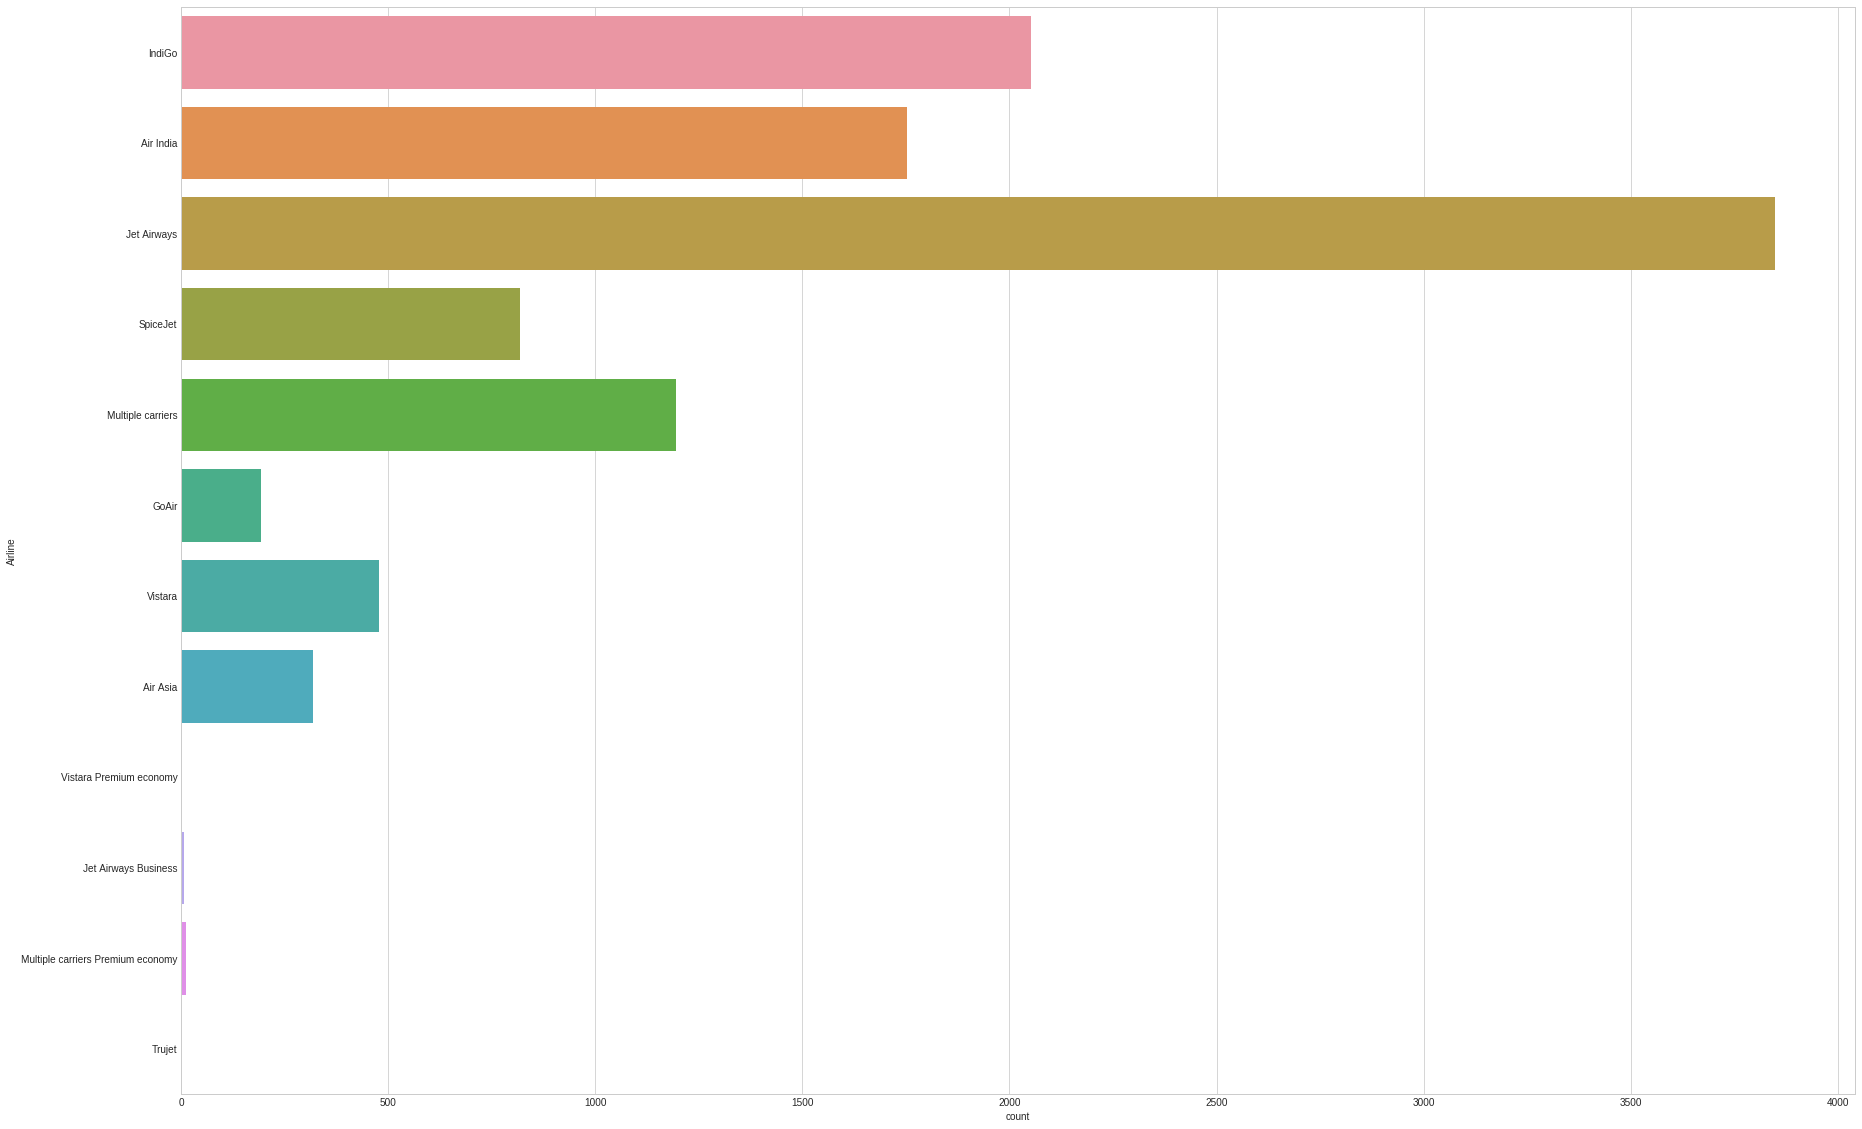

In [76]:
fig = plt.figure(figsize = (30,20))
sns.countplot(y = 'Airline', data = train)
print(df_bin.Airline.value_counts())

### Date Of Journey 

In [88]:
df_bin.Date_of_Journey.value_counts()

18/05/2019    504
6/06/2019     503
21/05/2019    497
9/06/2019     495
12/06/2019    493
9/05/2019     484
21/03/2019    423
15/05/2019    405
27/05/2019    382
27/06/2019    355
24/06/2019    351
1/06/2019     342
3/06/2019     333
15/06/2019    328
24/03/2019    323
6/03/2019     308
27/03/2019    299
24/05/2019    286
6/05/2019     281
1/05/2019     277
12/05/2019    259
1/04/2019     257
3/03/2019     218
9/03/2019     200
15/03/2019    162
18/03/2019    156
01/03/2019    152
12/03/2019    142
9/04/2019     125
3/04/2019     110
21/06/2019    109
18/06/2019    105
09/03/2019    102
6/04/2019     100
03/03/2019     97
06/03/2019     95
27/04/2019     94
24/04/2019     92
3/05/2019      90
15/04/2019     89
21/04/2019     82
18/04/2019     67
12/04/2019     63
1/03/2019      47
Name: Date_of_Journey, dtype: int64

### Source of flight

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64


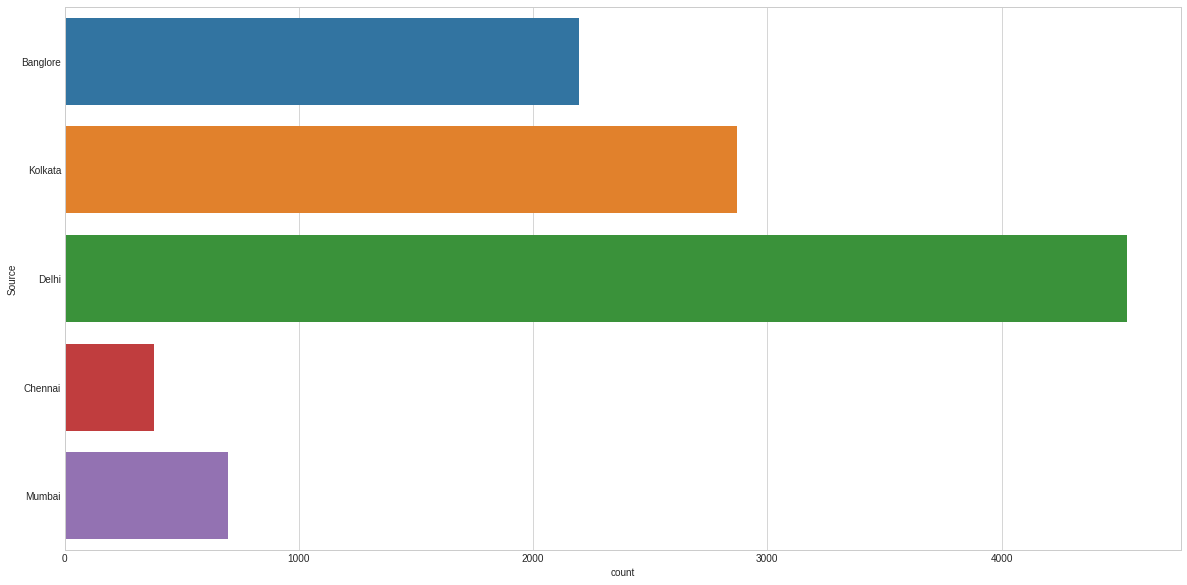

In [85]:
fig = plt.figure(figsize = (20,10))
sns.countplot(y = 'Source', data = train)
print(df_bin.Source.value_counts())

### Destination of flight

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64


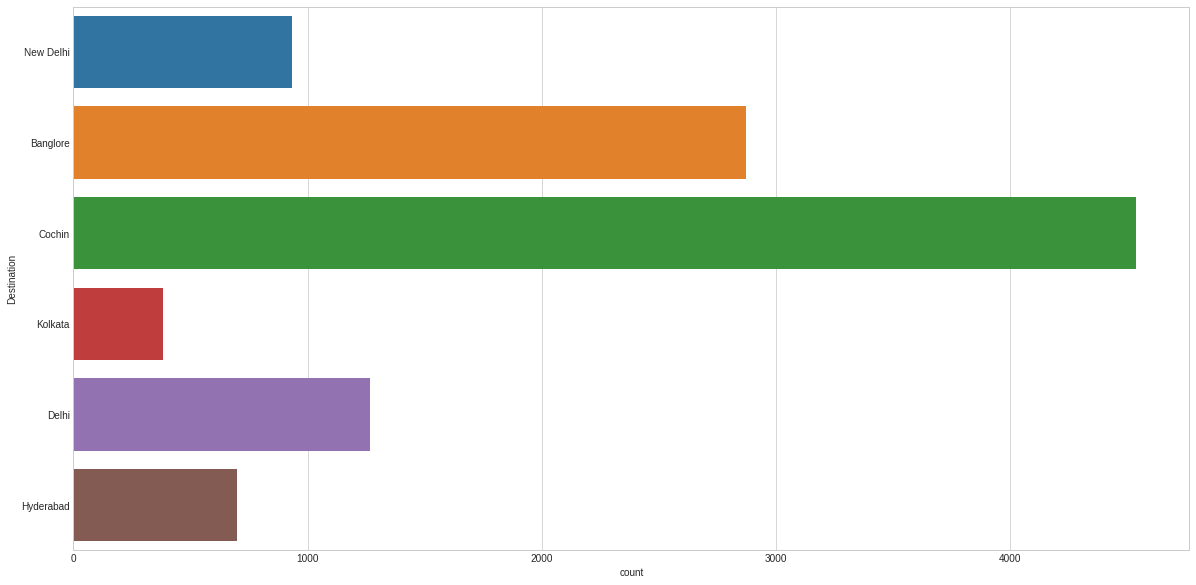

In [86]:
fig = plt.figure(figsize = (20,10))
sns.countplot(y = 'Destination', data = train)
print(df_bin.Destination.value_counts())